In [177]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm import tqdm
from sklearn.linear_model import LinearRegression

from datetime import datetime, timedelta

In [178]:
raw_data = pd.read_csv("1996 to 2023 CombinedData.csv")

In [179]:
raw_data.columns

Index(['Unnamed: 0', 'name', 'datetime', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions',
       'description', 'icon', 'stations'],
      dtype='object')

In [180]:
def plotSeasonality(df, col):
    fig, ax = plt.subplots(2, 2, figsize = (14, 14))

    df.boxplot(column = [col], by = "Month", ax = ax[0, 0])
    ax[0, 1].scatter(df["Month"], df[col])
    
    
    df.boxplot(column = [col], by = "Year", ax = ax[1, 0])
    ax[1, 1].scatter(df["Year"], df[col])

    
    ax[0, 0].set_title("Month - Box Plot")
    ax[0, 1].set_title("Month - Scatter Plot")
    ax[1, 0].set_title("Year - Box Plot")
    ax[1, 1].set_title("Year - Scatter Plot")
    
    plt.show()
    

# Check Monthly Seasonality

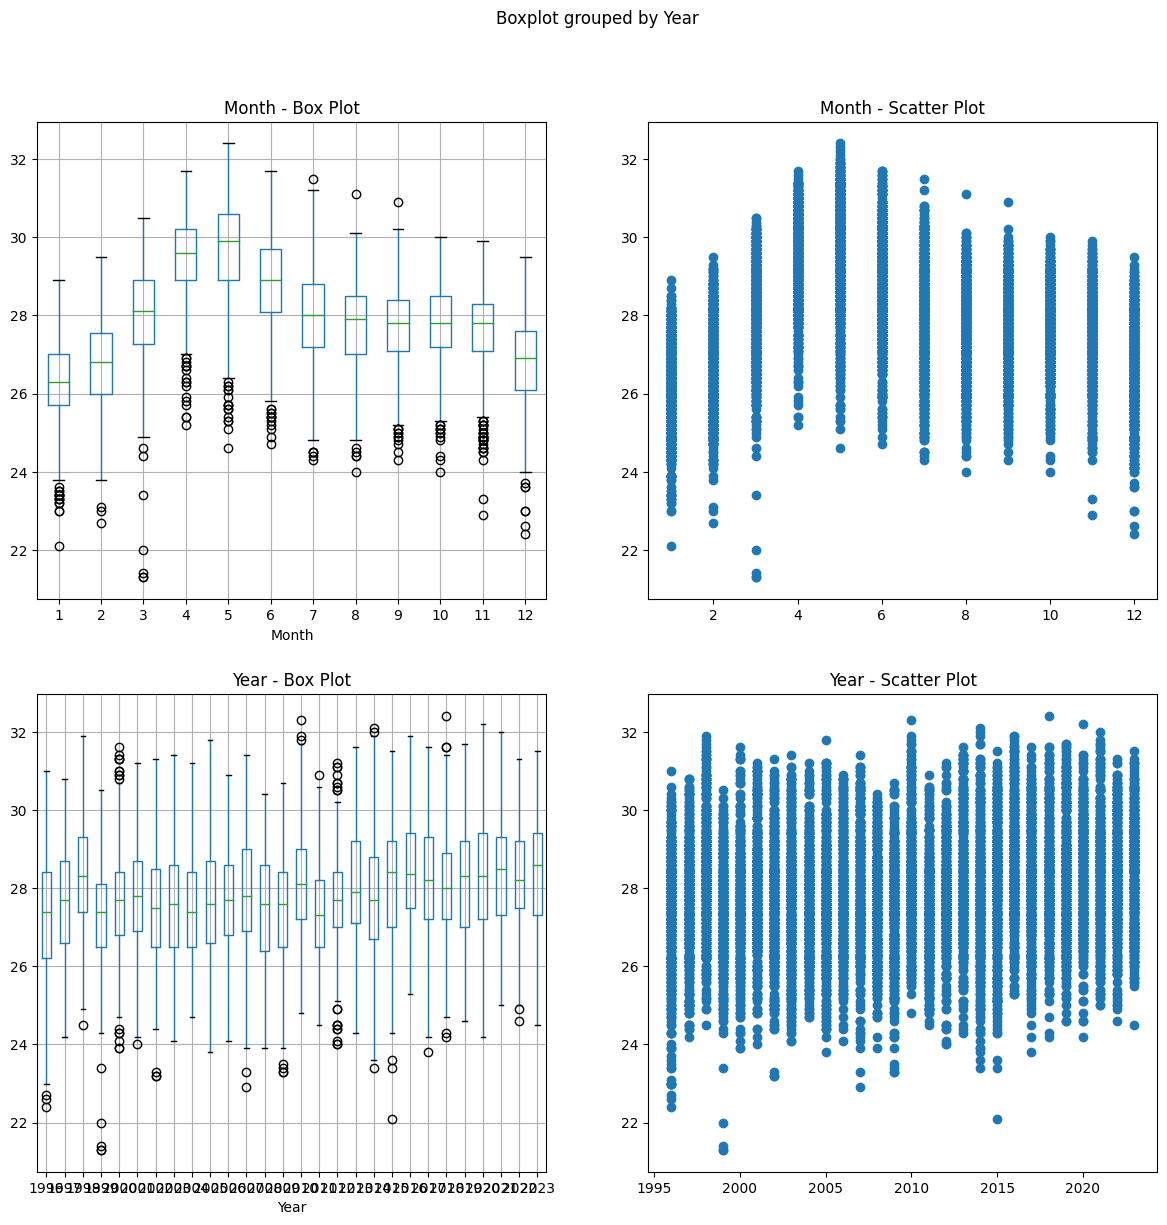

In [181]:
df = raw_data.copy()
df["Month"] = pd.DatetimeIndex(df["datetime"]).month
df["Year"] = pd.DatetimeIndex(df["datetime"]).year

plotSeasonality(df, "temp")


# Remove Monthly Mean

Since there is no seasonality (Or is there) found on the yearly data, but strong seasonality observed in Monthly Data

In [182]:
normalized_df = df.copy()
normalized_df["TempMod"] = normalized_df["temp"]

month_grp = normalized_df.groupby(by = "Month").mean(numeric_only = True)["temp"]

# For Every Month in the list of unique Months in the Dataframe
for month in normalized_df['Month'].unique():
    # Look for df["Month"] == current unique month, Change TempMod Value to be (currentTemp of the Day) - (Monthly Mean)
    normalized_df.loc[normalized_df['Month'] == month, 'TempMod'] -= month_grp[month]

# Get The Mean of the Normalized Month Groups
monthly_mean = normalized_df['TempMod'].mean()
print("Current Monthly Mean:", monthly_mean)

# Subtract the Normalized Temperature Mean by the Total Mean of all the other Normalized
normalized_df['TempMod'] = normalized_df['TempMod'] - monthly_mean
current_monthly_mean = normalized_df["TempMod"].mean()


Current Monthly Mean: -2.6679222697944507e-16


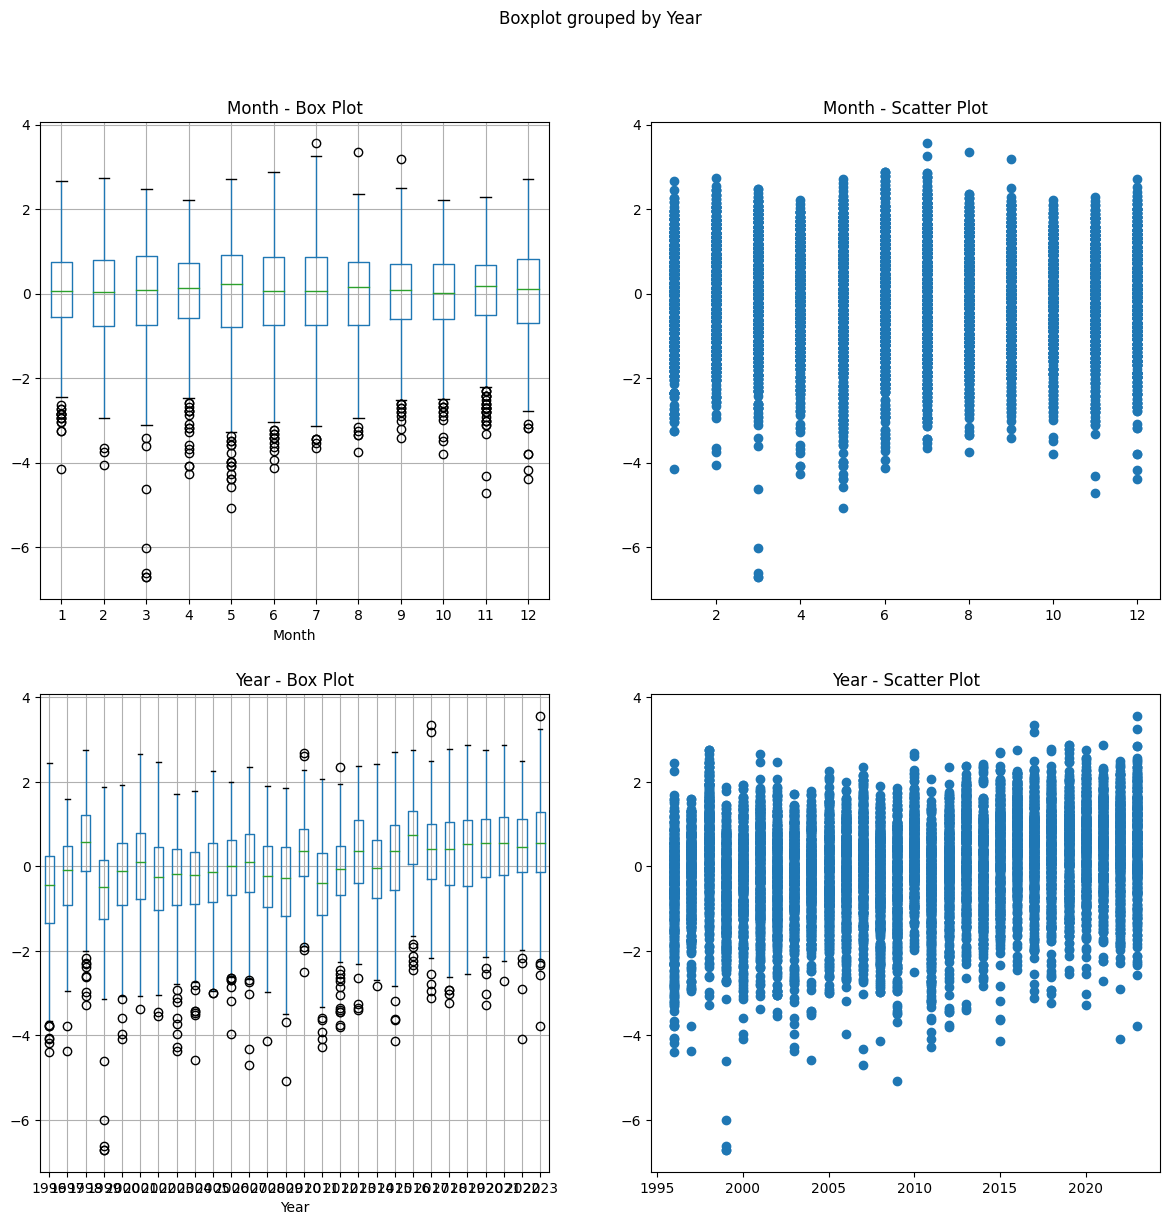

In [183]:
plotSeasonality(normalized_df, "TempMod")

In [184]:
normalized_df["TempMod"]

0       -2.842857
1       -1.942857
2       -2.742857
3       -3.242857
4       -3.242857
           ...   
10222    0.613479
10223    1.013479
10224    0.913479
10225    1.213479
10226    1.613479
Name: TempMod, Length: 10227, dtype: float64

In [185]:
MODEL_ORDER = 2
MODEL_PREDICTOR = LinearRegression()
MODEL_SIGMA = None 
MODEL_STD_SCALE = 0.8

In [186]:
def window_data(data):
    n = len(data)
    x = []
    y = []
    for i in range(n - MODEL_ORDER):
        x.append(data[i : i + MODEL_ORDER])
        y.append(data[i + MODEL_ORDER])
    
    return np.array(x), np.array(y)

In [187]:
train_data = normalized_df["TempMod"].to_numpy()
n = len(train_data)
split_point = int(0.7 * n)

MODEL_SIGMA = np.std(train_data[:split_point])
window_x, window_y = window_data(train_data)

train_x = window_x[:split_point]
test_x = window_x[split_point:]
train_y = window_y[:split_point]
test_y = window_y[split_point:]

In [188]:
MODEL_PREDICTOR.fit(train_x, train_y)

LinearRegression()

In [189]:
TARGET_YEAR = 2050
TARGET_MONTH = 12
TARGET_DATE = 31

target_datetime = datetime(TARGET_YEAR, TARGET_MONTH, TARGET_DATE)

StringFormat = "%Y-%M-%d"
raw_start_date = normalized_df["datetime"][MODEL_ORDER]
train_start_date = datetime.strptime(raw_start_date, StringFormat)
train_end_date = train_start_date + timedelta(days = len(train_y)) # + 1 Since Range

prediction_start_date = train_end_date # -1 + 1
prediction_end_date = datetime(TARGET_YEAR, TARGET_MONTH, TARGET_DATE) + timedelta(days = 1)

prediction_date_range = np.arange(prediction_start_date, prediction_end_date, timedelta(days = 1)).astype("datetime64[D]")
prediction_length = len(prediction_date_range)

# test_start_date = train_end_date + timedelta(days = 1)
# test_end_date = test_start_date + timedelta(days = len(preds)) # + 1 Since Range <

In [190]:
prediction_date_range[-1], prediction_date_range[0], train_end_date

(numpy.datetime64('2050-12-31'),
 numpy.datetime64('2015-08-09'),
 datetime.datetime(2015, 8, 9, 0, 1))

In [191]:
test_len = len(test_x)
preds = np.array([])

# This should have the values of the last X 
r_queue = np.copy(train_x)[-MODEL_ORDER]

# num_predictions = test_len
# num_predictions = 50 * 365
num_predictions = prediction_length

for i in tqdm(range(num_predictions)):

    # Reshape and do not apply on rolling queue 
    tr = np.reshape(r_queue, (1, -1))
    resid = np.random.normal(loc = 0, scale = MODEL_SIGMA * MODEL_STD_SCALE)
    # resid = 0
    next_val = MODEL_PREDICTOR.predict(tr) + resid 

    preds = np.append(preds, next_val)

    r_queue = np.roll(r_queue, -1)
    r_queue[-1] = next_val



100%|██████████| 12929/12929 [00:01<00:00, 7247.27it/s]


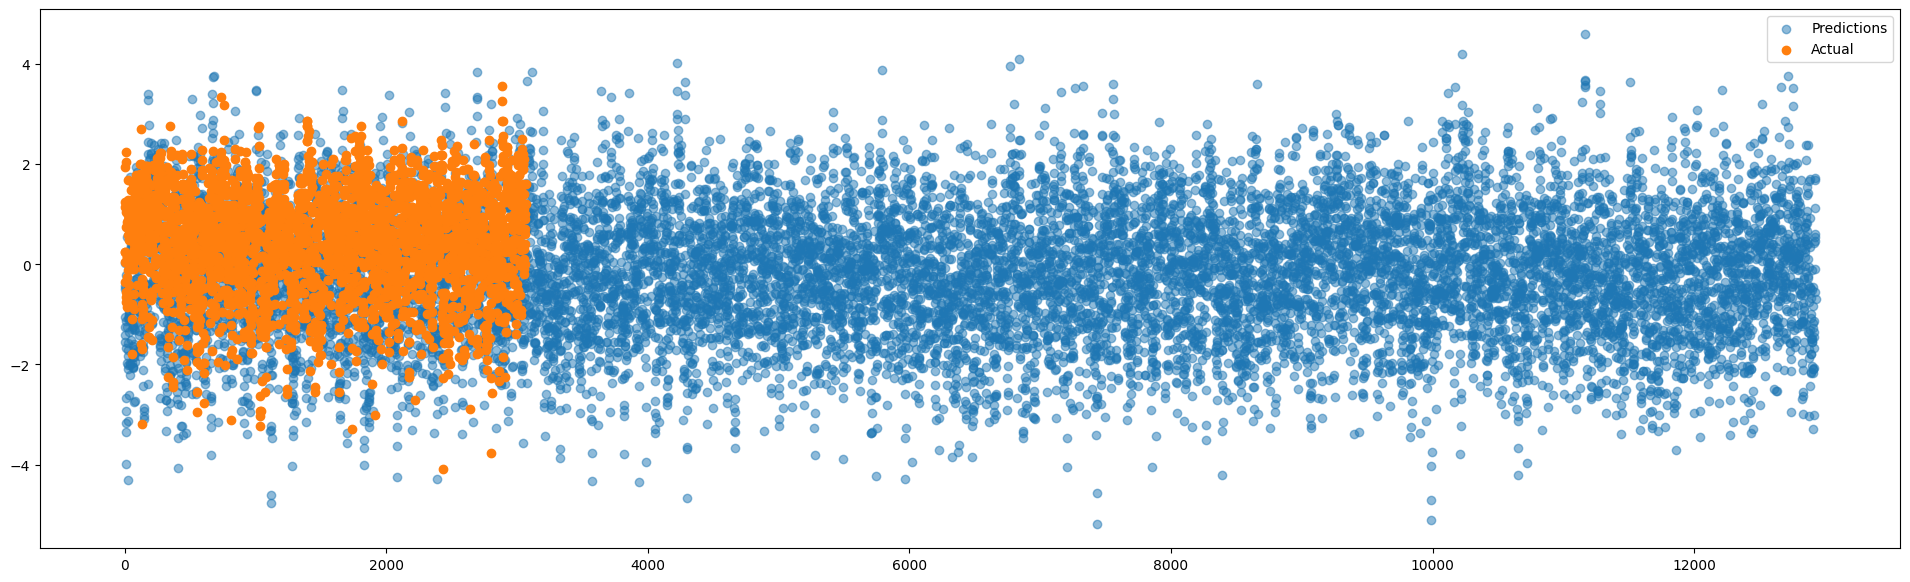

In [192]:
plt.figure(figsize=(24, 7))
plt.scatter(np.arange(0, len(preds)), preds, alpha = 0.5, label = "Predictions")
plt.scatter(np.arange(0, len(test_y)), test_y, label = "Actual")
plt.legend()
plt.show()

In [193]:
pred_df = normalized_df[["datetime", "TempMod"]]
pred_df

,datetime,TempMod
0,1996-01-01,-2.842857
1,1996-01-02,-1.942857
2,1996-01-03,-2.742857
3,1996-01-04,-3.242857
4,1996-01-05,-3.242857
...,...,...
10222,2023-12-27,0.613479
10223,2023-12-28,1.013479
10224,2023-12-29,0.913479
10225,2023-12-30,1.213479


In [194]:
preds.shape, train_y.shape, preds.shape[0] + train_y.shape[0] + MODEL_ORDER

((12929,), (7158,), 20089)

In [195]:
normalized_df["TempMod"][MODEL_ORDER], train_y[0]

(-2.7428571428571433, -2.7428571428571433)

In [196]:
normalized_df[["datetime", "TempMod"]][2:]

,datetime,TempMod
2,1996-01-03,-2.742857
3,1996-01-04,-3.242857
4,1996-01-05,-3.242857
5,1996-01-06,-1.342857
6,1996-01-07,-1.442857
...,...,...
10222,2023-12-27,0.613479
10223,2023-12-28,1.013479
10224,2023-12-29,0.913479
10225,2023-12-30,1.213479


In [197]:
train_y[0], train_y[-1]

(-2.7428571428571433, 1.4519585253456209)

In [198]:
normalized_df[["datetime", "TempMod"]].loc[MODEL_ORDER, ]

datetime    1996-01-03
TempMod      -2.742857
Name: 2, dtype: object

In [199]:
normalized_df[["datetime", "TempMod"]].loc[len(train_y) + MODEL_ORDER - 1, ]

datetime    2015-08-08
TempMod       1.451959
Name: 7159, dtype: object

In [200]:
StringFormat = "%Y-%M-%d"
raw_start_date = normalized_df["datetime"][MODEL_ORDER]
start_date = datetime.strptime(raw_start_date, StringFormat)
end_date = start_date + timedelta(days = len(train_y)) # + 1 Since Range <
test_start_date = end_date + timedelta(days = 1)
test_end_date = test_start_date + timedelta(days = len(preds)) # + 1 Since Range <

In [201]:
len(preds), len(preds) + len(train_y)

(12929, 20087)

In [202]:
start_date + timedelta(days = len(train_y) - 1), start_date

(datetime.datetime(2015, 8, 8, 0, 1), datetime.datetime(1996, 1, 3, 0, 1))

In [203]:
test_end_date

datetime.datetime(2051, 1, 2, 0, 1)

In [204]:
training_date_range = np.arange(start_date, end_date, timedelta(days = 1)).astype("datetime64[D]")
testing_date_range = np.arange(test_start_date, test_end_date, timedelta(days = 1)).astype("datetime64[D]")


In [205]:
training_date_range.shape, train_y.shape, testing_date_range.shape, preds.shape

((7158,), (7158,), (12929,), (12929,))

In [206]:
full_datetime_range = np.concatenate((training_date_range, prediction_date_range))
full_datetime_range.shape

(20087,)

In [207]:
training_date_range

array(['1996-01-03', '1996-01-04', '1996-01-05', ..., '2015-08-06',
       '2015-08-07', '2015-08-08'], dtype='datetime64[D]')

In [208]:
full_datetime_range

array(['1996-01-03', '1996-01-04', '1996-01-05', ..., '2050-12-29',
       '2050-12-30', '2050-12-31'], dtype='datetime64[D]')

In [209]:
prediction_date_range

array(['2015-08-09', '2015-08-10', '2015-08-11', ..., '2050-12-29',
       '2050-12-30', '2050-12-31'], dtype='datetime64[D]')

In [210]:
preds.shape, prediction_date_range.shape

((12929,), (12929,))

In [211]:
concatenated_preds = np.concatenate((train_y, preds))

In [212]:
concatenated_preds.shape, full_datetime_range.shape, (concatenated_preds.shape[0] - full_datetime_range.shape[0]) / 365

((20087,), (20087,), 0.0)

In [213]:
constructed_df = pd.DataFrame({
    "datetime" : full_datetime_range,
    "temp" : concatenated_preds
})

In [214]:
constructed_df

,datetime,temp
0,1996-01-03,-2.742857
1,1996-01-04,-3.242857
2,1996-01-05,-3.242857
3,1996-01-06,-1.342857
4,1996-01-07,-1.442857
...,...,...
20082,2050-12-27,1.687866
20083,2050-12-28,0.601056
20084,2050-12-29,1.120973
20085,2050-12-30,-0.558233


In [215]:
orig_vals = normalized_df[["datetime", "TempMod"]]["TempMod"][2:].values
cons_val = constructed_df["temp"].values[:len(orig_vals)]
diffs = np.absolute(orig_vals - cons_val)


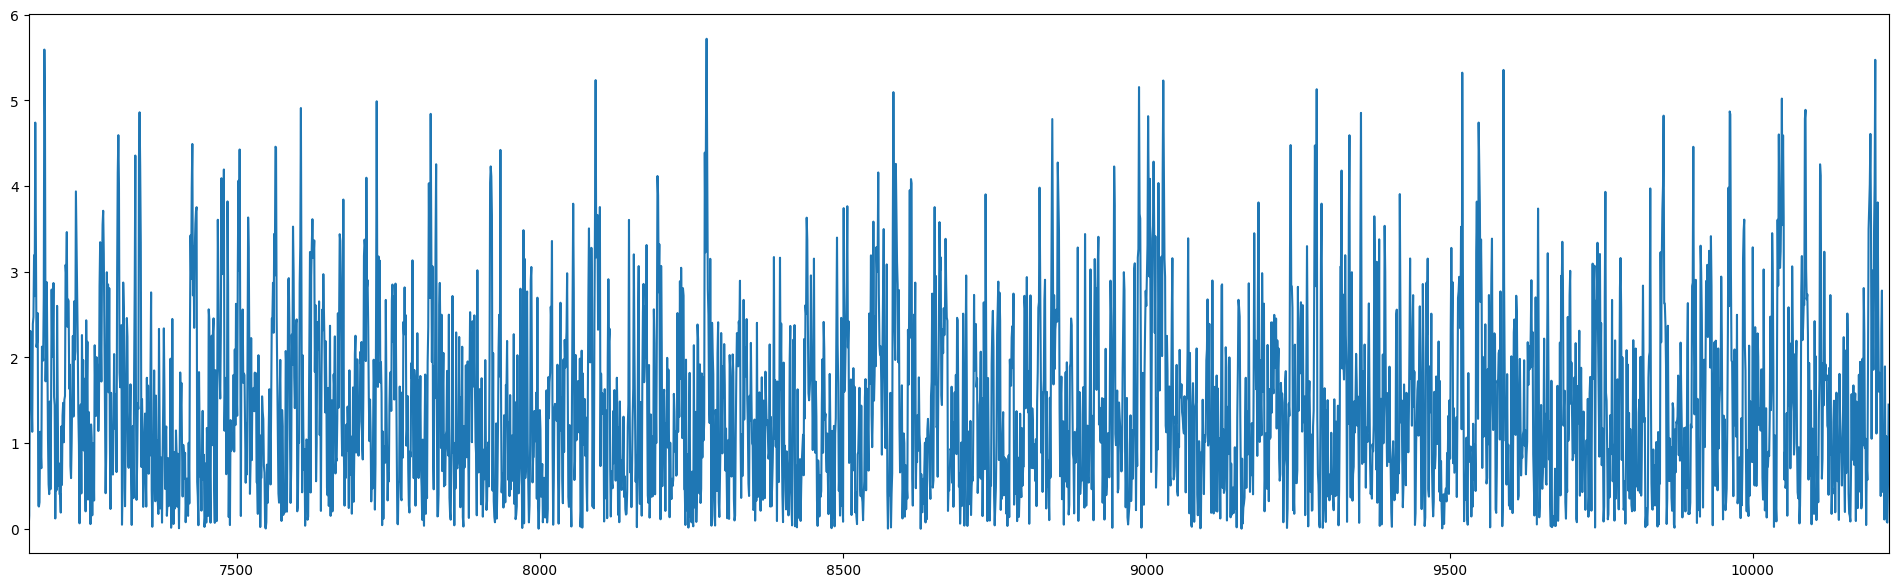

In [216]:
plt.figure(figsize=(24, 7))
plt.plot(diffs)
plt.xlim(len(cons_val) - len(test_y) - 1, len(cons_val) - 1)
plt.show()

In [217]:
# Reconstruct the Dates
# From Training X Add the dates
# Continue Dates until after Training X
# Add the Monthly Mean to Dataframe

In [218]:
constructed_df["Month"] = pd.DatetimeIndex(constructed_df["datetime"]).month

In [219]:
constructed_df["TempMod"] = constructed_df["temp"]

for month in constructed_df["Month"].unique():
    constructed_df.loc[constructed_df['Month'] == month, 'TempMod'] += month_grp[month]

constructed_df["TempMod"] += monthly_mean

<Axes: >

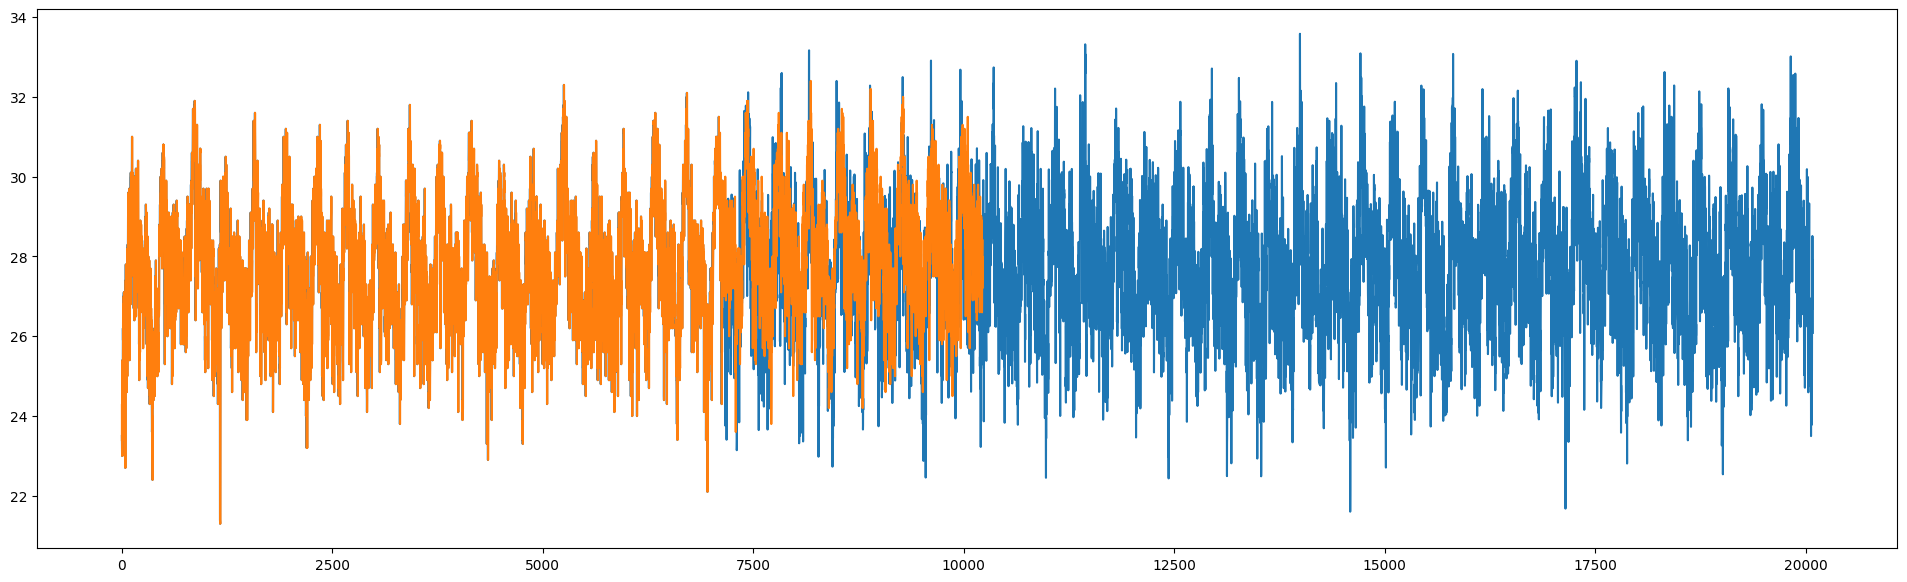

In [220]:
constructed_df["TempMod"].plot(figsize = (24, 7))
normalized_df["temp"].plot(figsize = (24, 7))

In [221]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [222]:
dec = constructed_df.copy()
# dec = df.copy()
dec.index = pd.DatetimeIndex(dec["datetime"])
dec["temp"] = dec["TempMod"]

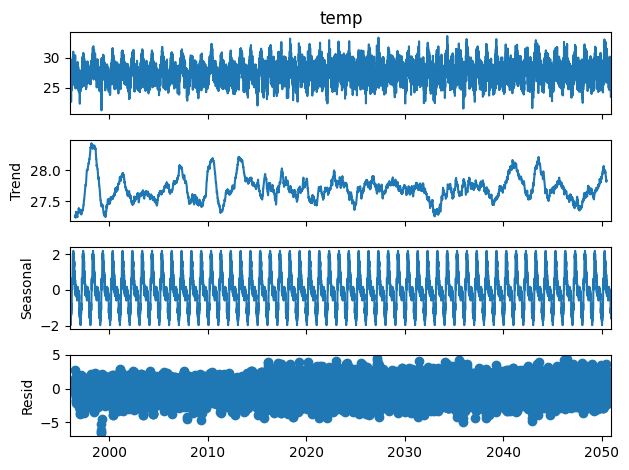

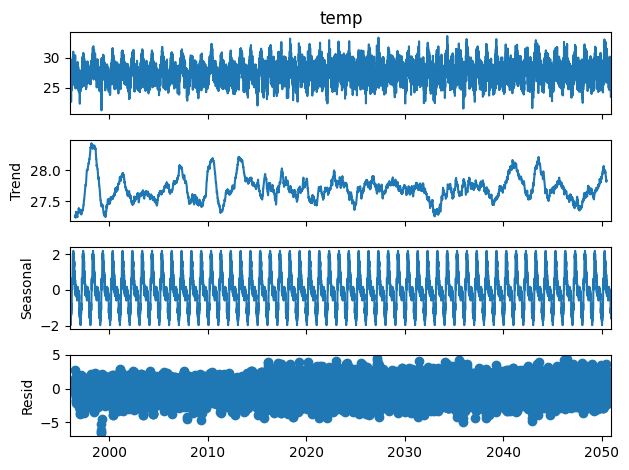

In [223]:

dec_result = seasonal_decompose(dec["temp"], model = "additive", period = 365)
# dec_result = seasonal_decompose(dec["temp"].copy(), model = "multiplicative")
dec_result.plot()


<Axes: xlabel='datetime'>

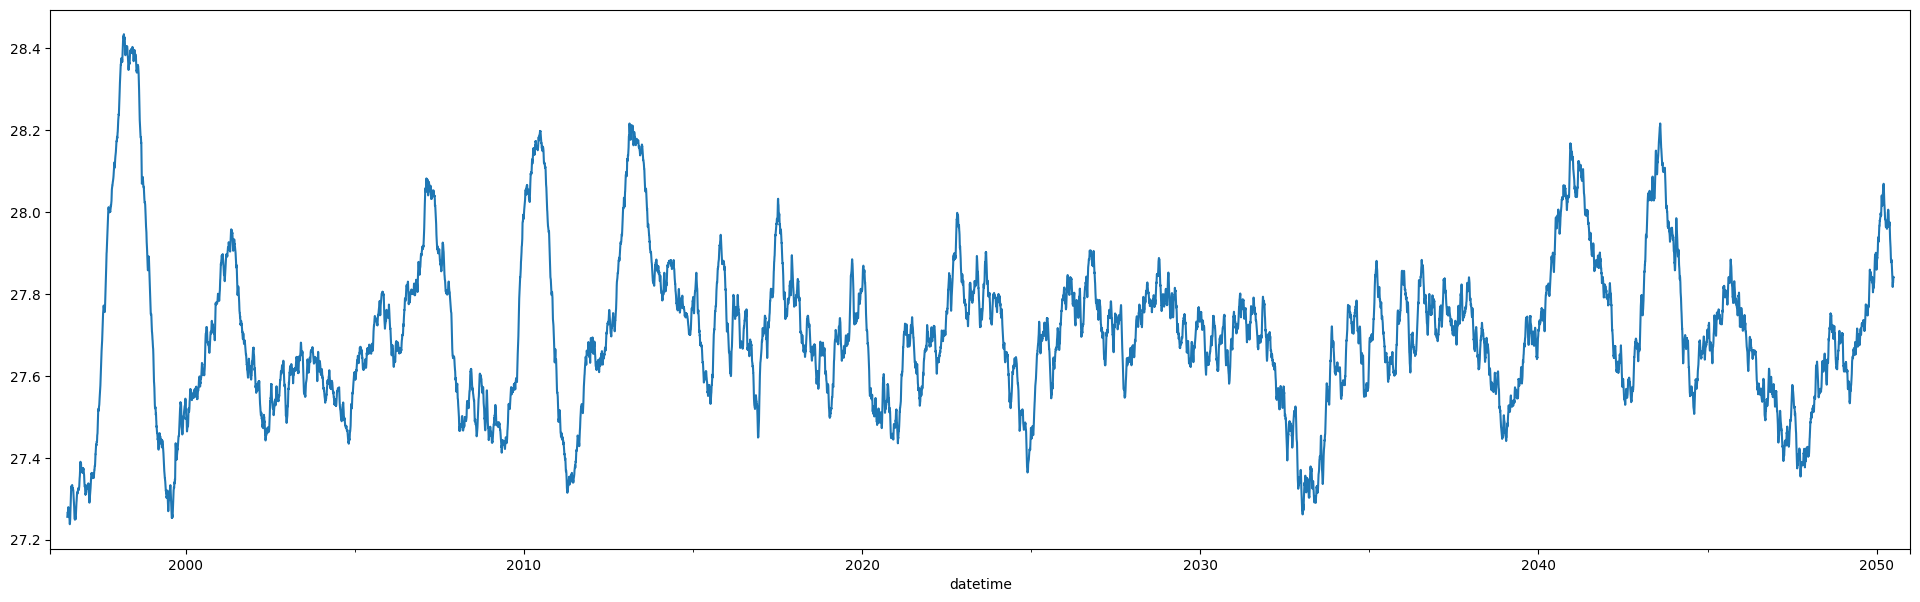

In [224]:
dec_result.trend.plot(figsize = (24, 7))

<Axes: xlabel='datetime'>

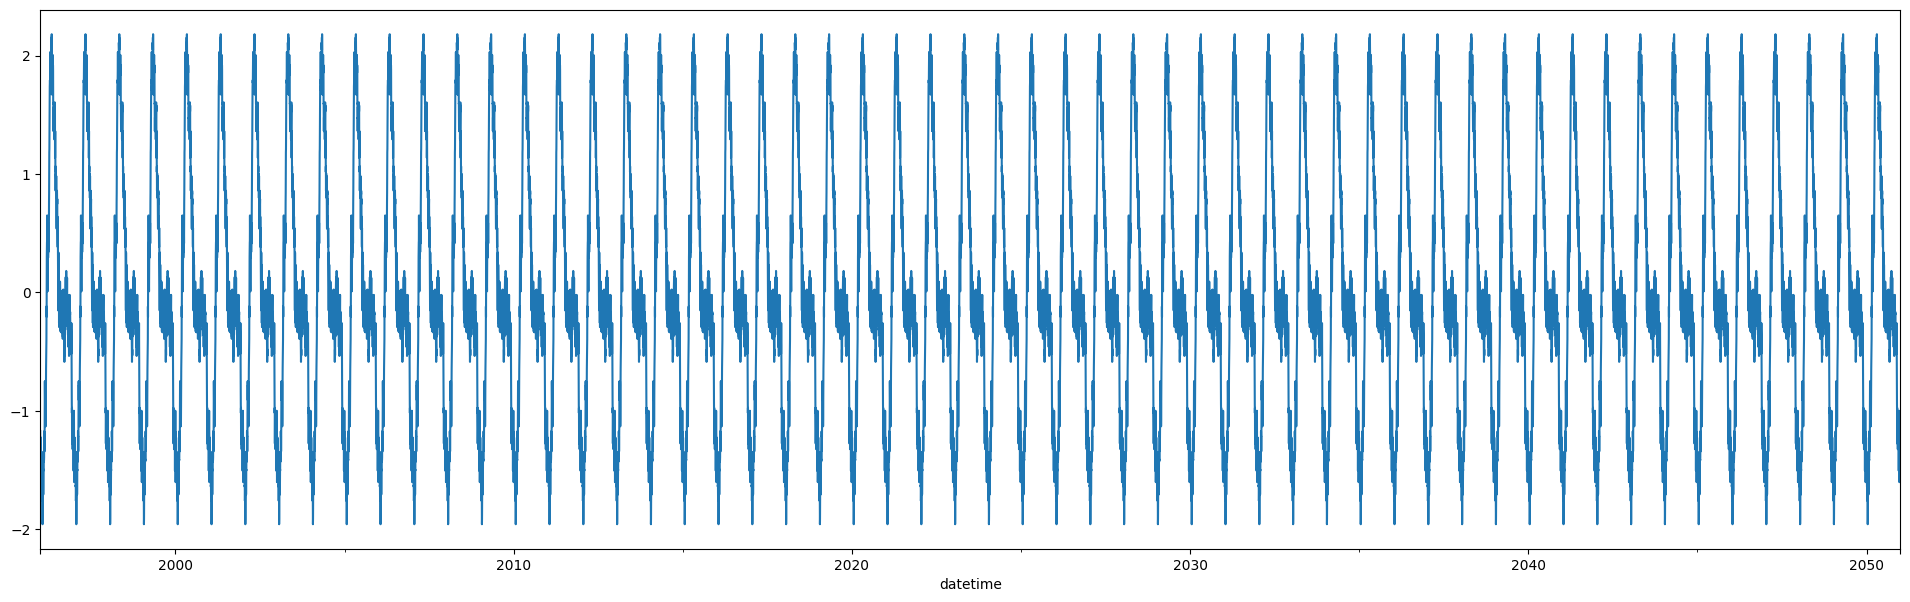

In [225]:
dec_result.seasonal.plot(figsize = (24, 7))

<Axes: xlabel='datetime'>

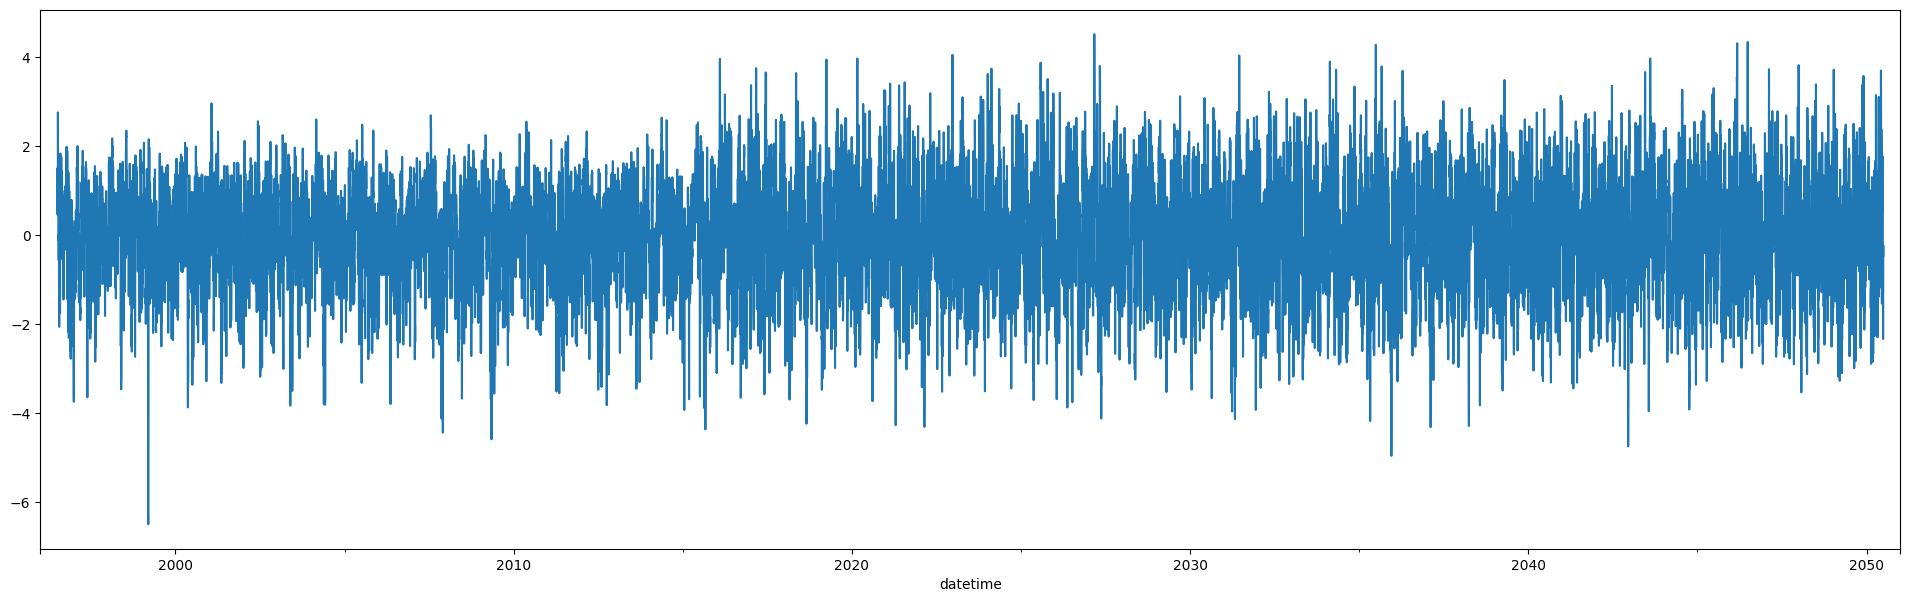

In [226]:
dec_result.resid.plot(figsize = (24, 7))

In [227]:
dec_result.trend.dropna()

datetime
1996-07-03    27.255890
1996-07-04    27.257808
1996-07-05    27.262740
1996-07-06    27.266575
1996-07-07    27.266575
                ...    
2050-06-28    27.836395
2050-06-29    27.837900
2050-06-30    27.841451
2050-07-01    27.840521
2050-07-02    27.840327
Name: trend, Length: 19723, dtype: float64

In [228]:
trend_examine = dec_result.trend.dropna()

In [229]:
sd = seasonal_decompose(trend_examine, model = "additive", period = 365)

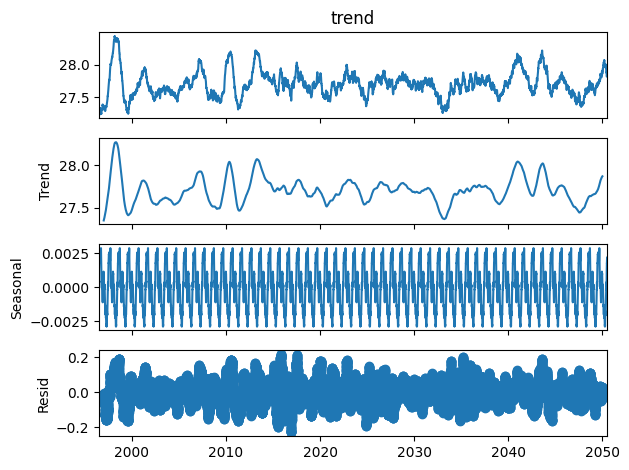

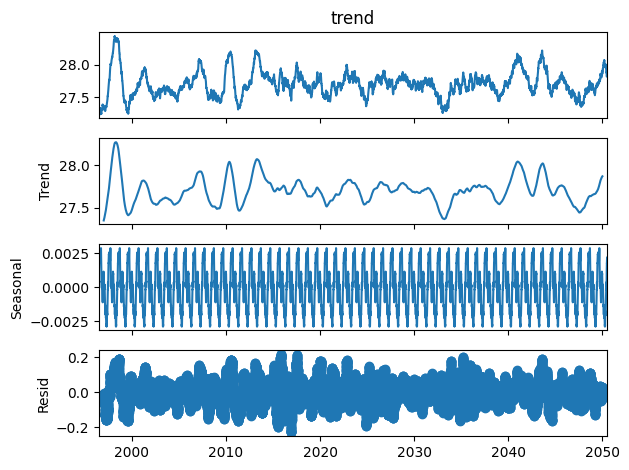

In [230]:
sd.plot()

In [231]:
trend_second_examine = sd.trend.dropna()

In [234]:
sd = seasonal_decompose(trend_second_examine, model = "additive")

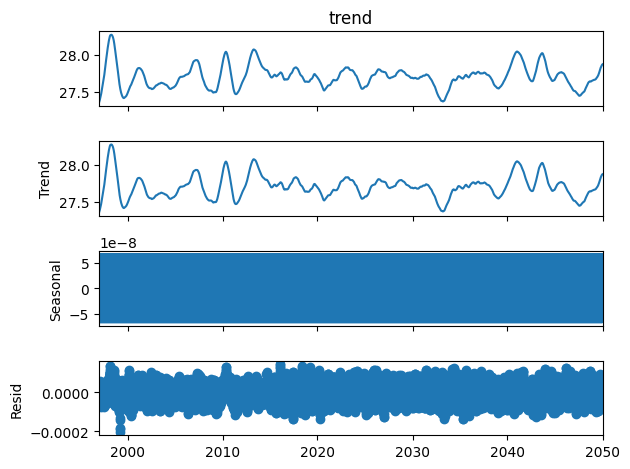

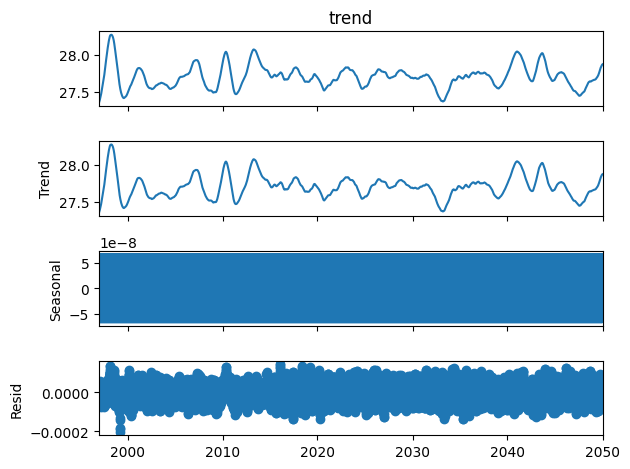

In [235]:
sd.plot()

In [240]:
constructed_df.head(5)

,datetime,temp,Month,TempMod
0,1996-01-03,-2.742857,1,23.5
1,1996-01-04,-3.242857,1,23.0
2,1996-01-05,-3.242857,1,23.0
3,1996-01-06,-1.342857,1,24.9
4,1996-01-07,-1.442857,1,24.8


In [241]:
normalized_df.head(5)

,Unnamed: 0,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,...,sunrise,sunset,moonphase,conditions,description,icon,stations,Month,Year,TempMod
0,0,"14.65, 121.05",1996-01-01,26.1,20.9,23.4,26.1,20.9,23.4,19.8,...,1996-01-01T06:20:44,1996-01-01T17:37:09,0.34,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"98432099999,98429099999,98428041224,9843409999...",1,1996,-2.842857
1,1,"14.65, 121.05",1996-01-02,28.1,20.7,24.3,29.7,20.7,24.8,19.8,...,1996-01-02T06:21:07,1996-01-02T17:37:43,0.37,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"98432099999,98429099999,98428041224,9843409999...",1,1996,-1.942857
2,2,"14.65, 121.05",1996-01-03,27.1,19.1,23.5,28.6,19.1,23.6,19.1,...,1996-01-03T06:21:28,1996-01-03T17:38:18,0.41,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"98432099999,98429099999,98430099999,69176499999",1,1996,-2.742857
3,3,"14.65, 121.05",1996-01-04,28.1,0.1,23.0,29.3,-5.5,23.0,17.7,...,1996-01-04T06:21:49,1996-01-04T17:38:53,0.44,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"98432099999,98429099999,98434099999,69176499999",1,1996,-3.242857
4,4,"14.65, 121.05",1996-01-05,26.6,19.1,23.0,26.6,19.1,23.0,18.3,...,1996-01-05T06:22:09,1996-01-05T17:39:27,0.48,Partially cloudy,Becoming cloudy in the afternoon.,partly-cloudy-day,"98432099999,98429099999,98428041224,9843409999...",1,1996,-3.242857


In [252]:
constructed_df["MonthYear"] = pd.DatetimeIndex(constructed_df["datetime"]).year * 1000_00 + pd.DatetimeIndex(constructed_df["datetime"]).month
normalized_df["MonthYear"] = pd.DatetimeIndex(normalized_df["datetime"]).year * 1000_00 + pd.DatetimeIndex(normalized_df["datetime"]).month

In [259]:
cons_grpings = constructed_df.groupby(by = "MonthYear").mean(numeric_only = True)
norm_grpings = normalized_df.groupby(by = "MonthYear").mean(numeric_only = True)
cg = cons_grpings["TempMod"].to_numpy()
ng = norm_grpings["temp"].to_numpy()

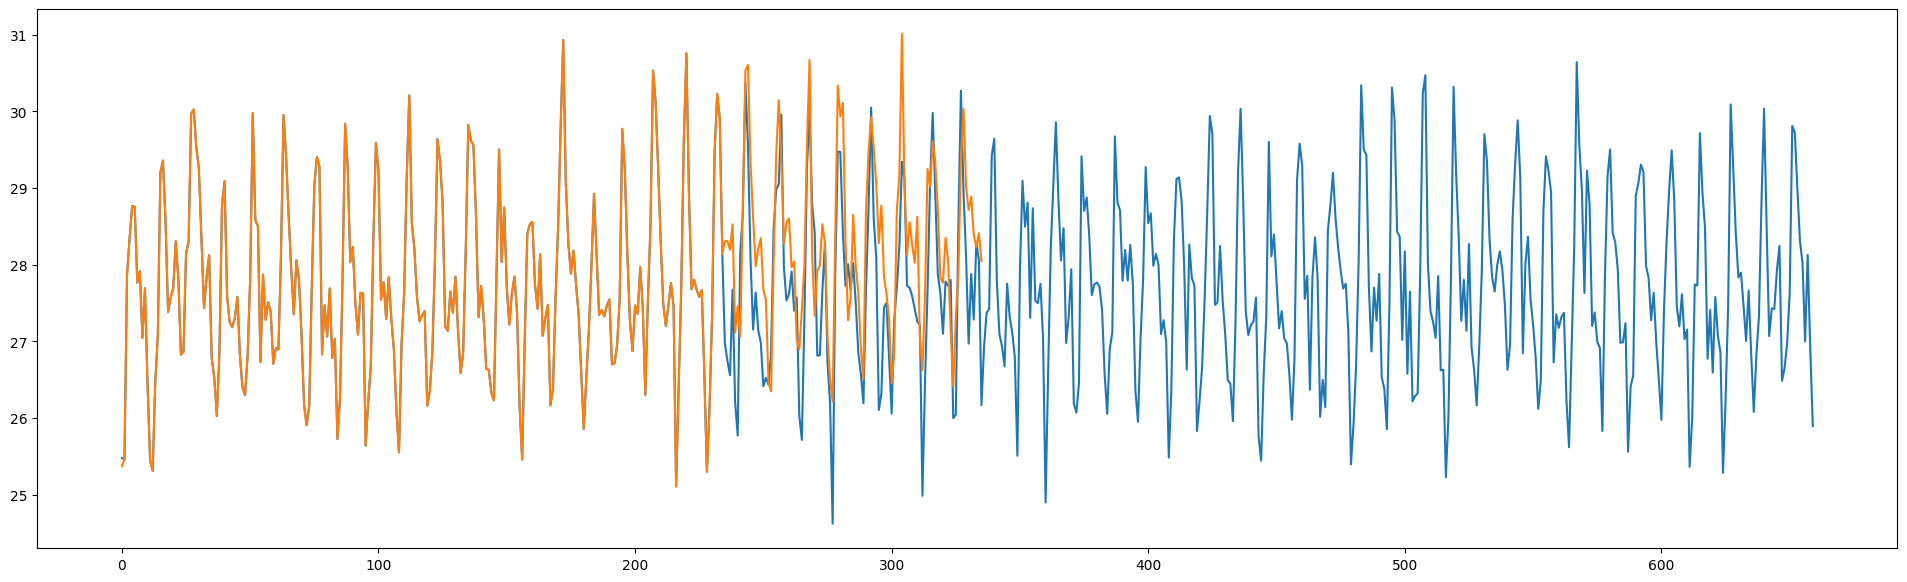

In [260]:
plt.figure(figsize = (24, 7))
plt.plot(cg)
plt.plot(ng)
plt.show()